# Goal
Develop a chess engine using 2 different methodologies:
- Classic (Minimax + Pruning) - like Stockfish
- Reinforcement Learning - like AlphaZero

Before digging in, let's start with the basics.

## Chess Board

We will use the library python-chess, which provides methods to build a board, generate moves, move validation, and so on.

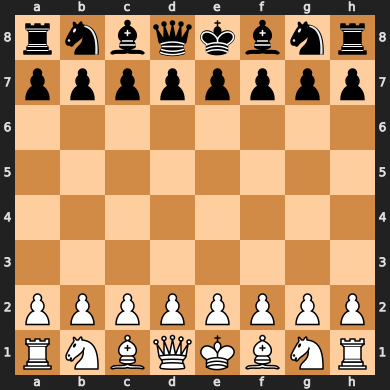

In [1]:
import chess
board = chess.Board()
board

In [2]:
# This is the text representation
print(board)
print()
print(board.unicode())

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R

♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜
♟ ♟ ♟ ♟ ♟ ♟ ♟ ♟
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♙ ♙ ♙ ♙ ♙ ♙ ♙ ♙
♖ ♘ ♗ ♕ ♔ ♗ ♘ ♖


In the board class we have different attributes that store information on turn, castling rights, pawn promotion, en passant, checks and others.

In [3]:
print("White to move:", board.turn) # True if white to move, False if black to move
print("#moves:", board.fullmove_number) # Number of moves
print("Move log:", board.move_stack) # Moves log

White to move: True
#moves: 1
Move log: []


## Chess Moves
The python-chess library conveniently provides methods to generate valid moves, make and undo moves. Let's see how.

In [4]:
# returns an iterator with all legal moves in the position
board.legal_moves

<LegalMoveGenerator at 0x1d7ef6c98b0 (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, b3, a3, h4, g4, f4, e4, d4, c4, b4, a4)>

In [5]:
import random
random_move = random.choice(list(board.legal_moves))
random_move

Move.from_uci('f2f3')

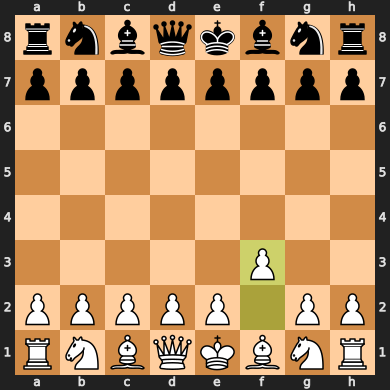

In [6]:
board.push(random_move)
board

In [7]:
print(board.turn) # True if white to move, False if black to move
print(board.halfmove_clock) # Number of "half-moves"
print(board.fullmove_number) # Number of moves
print(board.move_stack) # Moves log

False
0
1
[Move.from_uci('f2f3')]


We can also UNDO moves and return to the previous board state.

This will be particularly useful for our classic minimax engine.

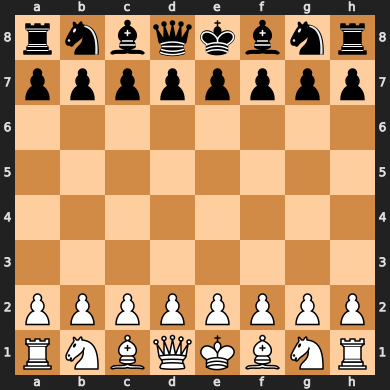

In [8]:
board.pop()
board

Let's input a list of moves to see the engine play a full game.

In [9]:
import chess.svg
from IPython.display import display
from ipywidgets import Button, Output, HBox

# Create a list of moves
moves = ["d4", "d5", "Bf4", "Nf6", "e3", "Nc6", "c3", "Bf5", "h3", "e6", "Nf3", "Bxb1", "Rxb1", 
         "Bd6", "Bh2", "Bxh2", "Nxh2", "O-O", "Bd3", "e5", "dxe5", "Nxe5", "Bc2", "c5", "O-O",
        "Qd6", "f4", "Nc4", "Qe2", "Rfd8", "Bd3", "Nb6", "Ng4", "Nxg4", "Qxg4", "c4", "Bc2", "f6",
        "Qh4", "h6", "Qh5", "g5", "Qg6+", "Kf8", "Qxh6+", "Ke7", "fxg5", "fxg5", "Qg7+", "Ke8", 
         "Qf7#"]

def draw_match(moves):

    # Create a chess board
    board = chess.Board()

    # List of board images
    board_svg_list = []

    # Function to create the svg image of the board
    def create_svg(last_move):
        board_svg = chess.svg.board(board=board, lastmove=last_move, size=400)
        board_svg_list.append(board_svg)

    # Function to update the board with a move
    def update_board(move):
        board.push_san(move)
        create_svg(board.move_stack[-1])

    # Create svg of initial board
    create_svg(None)

    # Iterate through the moves and update the board
    for move in moves:
        update_board(move)

    # Initialize the index to keep track of the current position
    position_index = 0  # Mutable variable

    # Function to update the board display
    def draw_board():
        nonlocal board_output, position_index
        with board_output:
            board_output.clear_output()
            display(board_svg_list[position_index])

    # Function to handle the button click events
    def prev_button_clicked(_):
        nonlocal position_index
        position_index = max(0, position_index - 1)
        draw_board()

    def next_button_clicked(_):
        nonlocal position_index
        position_index = min(len(board_svg_list) - 1, position_index + 1)
        draw_board()

    # Create an output widget to display the board
    board_output = Output()

    # Create buttons for navigation
    prev_button = Button(description="<")
    next_button = Button(description=">")

    # Add click event handlers to the buttons
    prev_button.on_click(prev_button_clicked)
    next_button.on_click(next_button_clicked)
    buttons_box = HBox([prev_button, next_button])

    # Display the initial board
    draw_board()
    display(board_output)
    display(buttons_box)

draw_match(moves)

Output()

## Minimax Agent
Now that we have our functioning chess board, let's start building our first AI Agent, using a tree-based algorithm called MiniMax.

It is called minimax, because it has 2 different goals: maximize your score, while minimizing the score of your opponent.

Example with depth 1:
- for each valid move compute the board score after making the move
- choose the move with the MAX score

Example with depth 2:
- for each valid move (my_move):
    - for each opponent valid move compute the board score after that move
    - take opponent MAX possible score
- choose my_move such that we take the MIN of the opponent MAX scores

and so on recursively.

![minimax](../images/400px-Minimax.svg.png)

First thing, we need a way to evaluate the board position, so that we can tell the agent if a position is better than another.

To do this the simplest way is to just consider material.

In [10]:
piece_score = {"K": 1000, "Q": 9, "R": 5, "B": 3, "N": 3, "p": 1}

This will lead to a very very naive agent, because score material is just a small component of a position evaluation.

Piece position, piece activity (protections/attacks), passed pawns, pawn structure are as important if not more as material score.

And king safety more important than any of those.

While we could be a position estimator from scratch, for our purpose it's efficient to use an existing one, aka **StockFish**, one of the (if not the) most famous and strong chess engine.

You can download it from here: https://stockfishchess.org/download/windows/

Let's see how to use it to analyse a chess position board.

In [12]:
import chess.engine

# Create a chess board
board = chess.Board()

# Create a stockfish engine instance
stockfish = chess.engine.SimpleEngine.popen_uci("../../stockfish-windows-2022-x86-64-avx2")

# Analyse board with stockfish
stockfish.analyse(board=board, limit=chess.engine.Limit(depth=2))

{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled',
 'depth': 2,
 'seldepth': 2,
 'multipv': 1,
 'score': PovScore(Cp(+46), WHITE),
 'nodes': 66,
 'nps': 33000,
 'hashfull': 0,
 'tbhits': 0,
 'time': 0.002,
 'pv': [Move.from_uci('d2d4')]}

What we care about is the score, expressed in centipawn (1/100 of a pawn).

Another important piece of information is the pv, which contains the best move found by stockfish.

With this, we can now build our max and min agents.

In [13]:
def max_agent(board, stockfish, depth, max_depth, player_multiplier, debug=False):
    
    # if I reach a leaf
    if depth == max_depth:
        
        # return the score from the point of view of the player
        # if player is white a positive score is good, if player is black a negative score is good
        # to achieve this we multiply by 1 if player is white, and by -1 if player is black
        return player_multiplier * stockfish.analyse(board=board, limit=chess.engine.Limit(depth=1))\
    ["score"].relative.score(mate_score=10000), None
    
    # start with a high negative score
    max_score = -10000
    best_move = None
    
    # for each valid move
    for move in board.legal_moves:
        
        # make the move
        board.push(move)
        
        if debug: print("\t"*depth, f"If I play {move}:")
        
        # get the minimum possible score that I could get after my opponent move
        score, _ = min_agent(board, stockfish, depth + 1, max_depth, -player_multiplier, debug=debug)
        
        if debug: print("\t"*depth, f"I will get {score} if my opponent plays its best move")

        # undo the move
        board.pop()
        
        # if the score is the best, override max score
        if score > max_score:
            max_score = score

            # if we are at the root, set the best move to make
            if depth == 0:
                best_move = move
                if debug: return max_score, best_move

    return max_score, best_move


def min_agent(board, stockfish, depth, max_depth, player_multiplier, debug=False):
    
    # if I reach a leaf
    if depth == max_depth:
        
        # return the score from the point of view of the player
        # if player is white a positive score is good, if player is black a negative score is good
        # to achieve this we multiply by 1 if player is white, and by -1 if player is black
        return player_multiplier * stockfish.analyse(board=board, limit=chess.engine.Limit(depth=1))\
    ["score"].relative.score(mate_score=10000), None
    
    # start with a high positive score
    min_score = 10000
    
    # for each valid move
    for move in board.legal_moves:
        
        # make the move
        board.push(move)
        
        if debug: print("\t"*depth, f"My opponent can play {move}:")
        
        # get the maximum possible score that I could get after my opponent move
        score, _ = max_agent(board, stockfish, depth + 1, max_depth, -player_multiplier, debug=debug)
        
        if debug: print("\t"*depth, f"I will get {score} if I play my best move")

        # undo the move
        board.pop()
        
        # if the score is the worst, override min score
        if score < min_score:
            min_score = score

    return min_score, None

In [14]:
max_agent(chess.Board(), stockfish, 0, 3, 1 if board.turn else -1, debug=True)

 If I play g1h3:
	 My opponent can play g8h6:
		 If I play h3g5:
		 I will get 0 if my opponent plays its best move
		 If I play h3f4:
		 I will get -20 if my opponent plays its best move
		 If I play h3g1:
		 I will get 4 if my opponent plays its best move
		 If I play h1g1:
		 I will get -79 if my opponent plays its best move
		 If I play b1c3:
		 I will get 19 if my opponent plays its best move
		 If I play b1a3:
		 I will get -17 if my opponent plays its best move
		 If I play g2g3:
		 I will get 12 if my opponent plays its best move
		 If I play f2f3:
		 I will get -8 if my opponent plays its best move
		 If I play e2e3:
		 I will get 5 if my opponent plays its best move
		 If I play d2d3:
		 I will get 1 if my opponent plays its best move
		 If I play c2c3:
		 I will get -1 if my opponent plays its best move
		 If I play b2b3:
		 I will get -16 if my opponent plays its best move
		 If I play a2a3:
		 I will get -8 if my opponent plays its best move
		 If I play g2g4:
		 I will ge

		 I will get -30 if my opponent plays its best move
		 If I play d2d3:
		 I will get -20 if my opponent plays its best move
		 If I play c2c3:
		 I will get -29 if my opponent plays its best move
		 If I play b2b3:
		 I will get -39 if my opponent plays its best move
		 If I play a2a3:
		 I will get -29 if my opponent plays its best move
		 If I play g2g4:
		 I will get -153 if my opponent plays its best move
		 If I play f2f4:
		 I will get -55 if my opponent plays its best move
		 If I play e2e4:
		 I will get -32 if my opponent plays its best move
		 If I play d2d4:
		 I will get -9 if my opponent plays its best move
		 If I play c2c4:
		 I will get -11 if my opponent plays its best move
		 If I play b2b4:
		 I will get -55 if my opponent plays its best move
		 If I play a2a4:
		 I will get -32 if my opponent plays its best move
	 I will get -3 if I play my best move
	 My opponent can play c7c6:
		 If I play h3g5:
		 I will get -39 if my opponent plays its best move
		 If I play h3

		 I will get -135 if my opponent plays its best move
		 If I play b1c3:
		 I will get -32 if my opponent plays its best move
		 If I play b1a3:
		 I will get -52 if my opponent plays its best move
		 If I play g2g3:
		 I will get -27 if my opponent plays its best move
		 If I play f2f3:
		 I will get -53 if my opponent plays its best move
		 If I play e2e3:
		 I will get -27 if my opponent plays its best move
		 If I play d2d3:
		 I will get -38 if my opponent plays its best move
		 If I play c2c3:
		 I will get -38 if my opponent plays its best move
		 If I play b2b3:
		 I will get -49 if my opponent plays its best move
		 If I play a2a3:
		 I will get -50 if my opponent plays its best move
		 If I play g2g4:
		 I will get -107 if my opponent plays its best move
		 If I play f2f4:
		 I will get -49 if my opponent plays its best move
		 If I play e2e4:
		 I will get -18 if my opponent plays its best move
		 If I play d2d4:
		 I will get -81 if my opponent plays its best move
		 If I p

(-50, Move.from_uci('g1h3'))

To show what's going on let's print the log setting debug=True

Note that setting debug=True will return after testing just the first branch, it is just to shorten the log print!!

In [16]:
max_agent(chess.Board(), stockfish, 0, 3, 1 if board.turn else -1)

(29, Move.from_uci('d2d4'))

With depth = 3, our minimax agent chooses the move pawn to d4, a great starting move.

We can achieve the same result in a more concise way, by combining the 2 agent (max and min) in a single agent, using an algorithm called negamax.

In [17]:
def negamax_agent(board, stockfish, depth, max_depth, player_multiplier):
    
    # if I reach a leaf
    if depth == max_depth:
        
        # return the score from the point of view of the player
        # if player is white a positive score is good, if player is black a negative score is good
        # to achieve this we multiply by 1 if player is white, and by -1 if player is black
        return player_multiplier * stockfish.analyse(board=board, limit=chess.engine.Limit(depth=1))\
    ["score"].relative.score(mate_score=10000), None
    
    # start with a high negative score
    max_score = -10000
    best_move = None
    
    # for each valid move
    for move in board.legal_moves:
        
        # make the move
        board.push(move)
                
        # call recursively the agent
        score, _ = negamax_agent(board, stockfish, depth + 1, max_depth, -player_multiplier)
        # invert the sign (to invert the goal from max to min and viceversa)
        score = -score
        
        # undo the move
        board.pop()
        
        # if the score is the best, override max score
        if score > max_score:
            max_score = score

            # if we are at the root, set the best move to make
            if depth == 0:
                best_move = move

    return max_score, best_move

In [18]:
negamax_agent(chess.Board(), stockfish, 0, 3, 1 if board.turn else -1)

(96, Move.from_uci('d2d3'))

Now, the problem with minimax/negamax (in chess) is that the number of valid moves is huge and as we increase the depth of the agent (to make it stronger by seeing more in the future) we will soon encounter time constraints.

A simple but effective way to speed up the process is called alpha/beta pruning, and it is used to "prune" the branches that 100% will not be chosen.

![alpha-beta pruning](../images/400px-AB_pruning.svg.png)

In this explanation I will use a notation like MAX5 to denote the MAX agent at depth = 5 (the last row) or MIN4 to denote the MIN agent at depth = 4.

In this image we can see at the bottom left that the MAX5 agent starts exploring the dark 5 branch. 

As soon as it gets a score >= 4 (the previous MAX5 branch) it can discard the whole branch. This is because the MIN4 agent will never choose that branch as its goal is to minimize the score and it will choose 4.

On the right we have a similar example.

The MAX5 in the leaves computes 9 and 8. MIN4 chooses 8. At this point it is not necessary to explore the branches on the right for the MIN4 (the 6) because the MAX3 will choose at least 8 and this will never be chosen by MIN2.

Let's see how this is done by changing slightly our negamax agent code.

In [19]:
def negamax_agent_alphabeta(board, stockfish, depth, max_depth, player_multiplier, alpha, beta):
    
    # if I reach a leaf
    if depth == max_depth:
        
        # return the score from the point of view of the player
        # if player is white a positive score is good, if player is black a negative score is good
        # to achieve this we multiply by 1 if player is white, and by -1 if player is black
        return player_multiplier * stockfish.analyse(board=board, limit=chess.engine.Limit(depth=1))\
    ["score"].relative.score(mate_score=10000), None
    
    # start with a high negative score
    max_score = -10000
    best_move = None
    
    # for each valid move
    for move in board.legal_moves:
        
        # make the move
        board.push(move)
                
        # call recursively the agent
        score, _ = negamax_agent_alphabeta(board, stockfish, depth + 1, max_depth, -player_multiplier, -beta, -alpha)
        # invert the sign (to invert the goal from max to min and viceversa)
        score = -score
        
        # undo the move
        board.pop()
            
        # if the score is the best, override max score
        if score > max_score:
            max_score = score

            # if we are at the root, set the best move to make
            if depth == 0:
                best_move = move

        # found a better reward?
        if max_score > alpha:
            alpha = max_score
            
        # if our score is higher than the current best reward for the previous agent
        # it will never choose this tree path
        if alpha >= beta:
            break
            
    return max_score, best_move

In [20]:
negamax_agent_alphabeta(chess.Board(), stockfish, 0, 3, 1 if board.turn else -1, -10000, 10000)

(96, Move.from_uci('d2d3'))

In [21]:
# close stockfish engine
stockfish.quit()

Let's now see how our minimax agent performs against an human player (I'm playing white and I'm an amateur chess player around 1500-1600 ELO on https://www.chess.com)

In [22]:
# minimax depth = 1
moves = moves = ["d4", "Nc6", "Bf4", "Nxd4", "Qxd4", "Nf6", "e3", "d5", "Nf3", "e5", "Bxe5", "Bd6", "Bxf6", 
         "Qxf6", "Qxf6", "gxf6", "Bd3", "Bxh2", "Nxh2", "Be6", "Nf3", "f5", "Nbd2", "f4", "exf4",
        "Kf8", "Rxh7", "Rxh7", "Bxh7", "Kg7", "Bd3", "Kg8", "Ng5", "Re8", "Nxe6", "Rxe6", "Kf1", "Re2", "Nf3",
        "Rxf2", "Kxf2", "d4", "Nxd4", "a6", "Re1", "a5", "Nf5", "a4", "Re8", "Kh7", "Ne7", "Kg7", "g4", "a3", "g5", 
         "axb2", "Rg8"]

draw_match(moves)

Output()

In [23]:
# minimax depth = 3
moves = ["d4", "Nc6", "Bf4", "Nf6", "e3", "Nd5", "Bg3", "d6", "c3", "Bf5", "Nf3", "Be4", "Nbd2", "Bxf3", "Nxf3", "Qd7", "Bd3",
"Qg4", "O-O", "e6", "Re1", "O-O-O", "h3", "Qh5", "a4", "Kb8", "a5", "Be7", "e4", "Nf6", "b4", "Rhe8", "b5", "Nxe4",
"Rxe4", "d5", "Re1", "Nxa5", "Rxa5", "e5", "Bxe5", "Ka8", "Qa1", "a6", "bxa6", "b6", "Ra2", "Bf8", "Qb2", "h6", "Qb5",
"Ka7", "Qc6", "Rb8", "Bxc7", "Rxe1+", "Nxe1", "Be7", "Bxb8+", "Kxb8", "Qb7#"]

draw_match(moves)

Output()

Minimax at depth 5 will be probably strong enough to beat me, or at least fight more.

But without any optimization the engine becomes VERY slow and makes it difficult to play a game against (can take 5-10min per move in the middle game)

### Next steps (Minimax)
Adding these (and many others) optimizations we could reach pretty good performance (Stockfish is built in a similar way):
- Transposition tables
- Principal variation search
- Move ordering
- Opening book
- Endgame tables

But we are not going to explore these in our project, because we are going to move on to the next phase, where we are going to build an engine based on Reinforcement Learning techniques.

[Go to next notebook - Reinforcement Learning](chess_engine_rl.ipynb)